In [ ]:
# Victor Z and David Cole
# UW-Madison, 2024
# Generator sizing example (two-stage formulation)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import weibull_min, mstats
from statsmodels.distributions.empirical_distribution import ECDF

# Function Definitions

def myfun(W, data):
    u = data['u']
    X1 = data['X1']
    X2 = data['X2']

    R = X1 + X2 - W
    y = 5 * (R**2) + 15 * u**2

    Q = np.quantile(y, 0.9)
    loc = y >= Q
    rho = np.mean(y[loc])
    return rho

def costfun(W, data):
    u = data['u']
    X1 = data['X1']
    X2 = data['X2']

    R = X1 + X2 - W
    y = 5 * (R**2) + 15 * u**2
    return y

def myfundet(W, data):
    u = data['u']
    X1 = data['X1']
    X2 = data['X2']

    R = X1 + X2 - W
    y = 5 * (R**2) + 15 * u**2
    return y

def mycon(W, data):
    u = data['u']
    X1 = data['X1']
    X2 = data['X2']

    con = [W - X1 - X2, W - u, -W]
    con = np.concatenate(con)
    return con, []

In [ ]:
# Generate scenarios for random load
np.random.seed(0)
N = 200
X1 = weibull_min.rvs(2, scale=10, size=N)
X2 = weibull_min.rvs(1, scale=2, size=N)

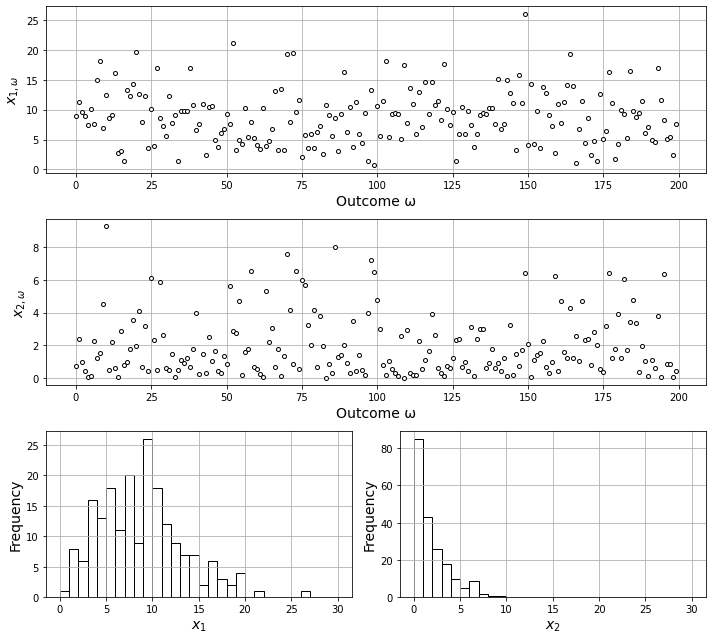

In [ ]:
# Plot data
fig = plt.figure(figsize=(10, 9))

# First two plots spanning two columns but on separate rows
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax1.plot(X1, 'o', color='black', markerfacecolor='w', markersize=4)
ax1.set_xlabel('Outcome ω', fontsize=14)
ax1.set_ylabel('$x_{1,ω}$', fontsize=14)
ax1.grid(True)

ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax2.plot(X2, 'o', color='black', markerfacecolor='w', markersize=4)
ax2.set_xlabel('Outcome ω', fontsize=14)
ax2.set_ylabel('$x_{2,ω}$', fontsize=14)
ax2.grid(True)

# Next two individual plots
ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.hist(X1, bins=np.arange(0, 31, 1), edgecolor='black', facecolor='white', linewidth=1)
ax3.set_xlabel('$x_1$', fontsize=14)
ax3.set_ylabel('Frequency', fontsize=14)
ax3.grid(True)

ax4 = plt.subplot2grid((3, 2), (2, 1))
ax4.hist(X2, bins=np.arange(0, 31, 1), edgecolor='black', facecolor='white', linewidth=1)
ax4.set_xlabel('$x_2$', fontsize=14)
ax4.set_ylabel('Frequency', fontsize=14)
ax4.grid(True)

fig.tight_layout()


In [ ]:
# Find deterministic solution
u = [1, 10]
opt_options = {'disp': False}

rho = []

for uk in u:
    data = {'X1': np.max(X1), 'X2': np.max(X2), 'u': uk}
    W0 = np.zeros(1)
    res = minimize(myfundet, W0, args=(data), constraints={'type': 'ineq', 'fun': lambda W: mycon(W, data)[0]}, options=opt_options)
    rho.append(myfundet(res.x, data))

udet = u[np.argmin(rho)]

In [ ]:
# Evaluate performance
data = {'X1': X1, 'X2': X2, 'u': udet}
W0 = np.zeros(N)
res = minimize(myfun, W0, args=(data), constraints={'type': 'ineq', 'fun': lambda W: mycon(W, data)[0]}, options=opt_options)
rhodet = myfun(res.x, data)

In [ ]:
# Find stochastic solution
rho = []

for uk in u:
    data = {'X1': X1, 'X2': X2, 'u': uk}
    W0 = np.zeros(N)
    res = minimize(myfun, W0, args=(data), constraints={'type': 'ineq', 'fun': lambda W: mycon(W, data)[0]}, options=opt_options)
    rho.append(myfun(res.x, data))

ustoch = u[np.argmin(rho)]

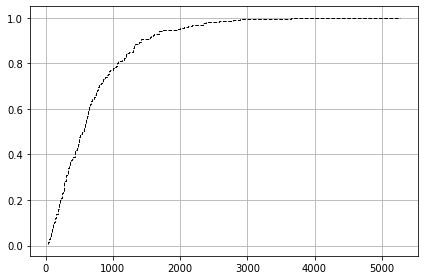

In [ ]:
# Evaluate performance
data = {'X1': X1, 'X2': X2, 'u': ustoch}
W0 = np.zeros(N)
res = minimize(myfun, W0, args=(data), constraints={'type': 'ineq', 'fun': lambda W: mycon(W, data)[0]}, options=opt_options)
rhostoch = myfun(res.x, data)

ystoch = costfun(res.x, data)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ecdf_ystoch = ECDF(ystoch)
axs.step(ecdf_ystoch.x, ecdf_ystoch.y, linewidth=1, color='black', linestyle='--')
axs.grid(True)

fig.tight_layout()
plt.show()